In [1]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [2]:
img_width, img_height, img_channels= 1024, 1024, 1
num_class=6
batch_size=1
epochs=20
train_dir='./cadmnist_segment/train/'
train_samples=20

In [ ]:
def batch_slice(inputs, graph_fn, batch_size, names=None):
    """Splits inputs into slices and feeds each slice to a copy of the given
    computation graph and then combines the results. It allows you to run a
    graph on a batch of inputs even if the graph is written to support one
    instance only.
    inputs: list of tensors. All must have the same first dimension length
    graph_fn: A function that returns a TF tensor that's part of a graph.
    batch_size: number of slices to divide the data into.
    names: If provided, assigns names to the resulting tensors.
    """
    if not isinstance(inputs, list):
        inputs = [inputs]
    outputs = []
    for i in range(batch_size):

        inputs_slice = [x[i] for x in inputs]
        output_slice = graph_fn(*inputs_slice)
        if not isinstance(output_slice, (tuple, list)):
            output_slice = [output_slice]
        outputs.append(output_slice)
    # Change outputs from a list of slices where each is
    # a list of outputs to a list of outputs and each has
    # a list of slices
    outputs = list(zip(*outputs))

    if names is None:
        names = [None] * len(outputs)

    result = [tf.stack(o, axis=0, name=n)
              for o, n in zip(outputs, names)]
    if len(result) == 1:
        result = result[0]

    return result
def apply_box_deltas_graph(boxes, deltas):
    """Applies the given deltas to the given boxes.
    boxes: [N, (y1, x1, y2, x2)] boxes to update
    deltas: [N, (dy, dx, log(dh), log(dw))] refinements to apply
    """
    # Convert to y, x, h, w
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height *= tf.exp(deltas[:, 2])
    width *= tf.exp(deltas[:, 3])
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    result = tf.stack([y1, x1, y2, x2], axis=1, name="apply_box_deltas_out")
    return result
def clip_boxes_graph(boxes, window):
    """
    boxes: [N, (y1, x1, y2, x2)]
    window: [4] in the form y1, x1, y2, x2
    """
    # Split
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=1)
    # Clip
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.concat([y1, x1, y2, x2], axis=1, name="clipped_boxes")
    clipped.set_shape((clipped.shape[0], 4))
    return clipped

class ProposalLayer(Layer):
    """Receives anchor scores and selects a subset to pass as proposals
    to the second stage. Filtering is done based on anchor scores and
    non-max suppression to remove overlaps. It also applies bounding
    box refinement deltas to anchors.
    Args:
        rpn_probs: [batch, num_anchors, (bg prob, fg prob)]
        rpn_bbox: [batch, num_anchors, (dy, dx, log(dh), log(dw))]
        anchors: [batch, num_anchors, (y1, x1, y2, x2)] anchors in normalized coordinates
    Returns:
        Proposals in normalized coordinates [batch, rois, (y1, x1, y2, x2)]
    """

    def __init__(self, proposal_count, config, name='roi', **kwargs):
        super(ProposalLayer, self).__init__(name=name, **kwargs)
        self.config = config
        self.proposal_count = proposal_count
        self.nms_threshold = self.config['rpn_nms_threshold']

    def nms(self, boxes, scores):
        indices = tf.image.non_max_suppression(boxes, scores, self.proposal_count, self.nms_threshold,
                                               name="rpn_non_max_suppression")
        proposals = tf.gather(boxes, indices)
        # Pad if needed
        padding = tf.maximum(self.proposal_count - tf.shape(proposals)[0], 0)
        proposals = tf.pad(proposals, [(0, padding), (0, 0)])
        return proposals

    def call(self, inputs, **kwargs):
        # Box Scores. Use the foreground class confidence. [Batch, num_rois, 1]
        scores = inputs[0][:, :, 1]
        # Box deltas [batch, num_rois, 4]
        deltas = inputs[1]
        deltas = deltas * np.reshape(self.config['rpn_bbox_std_dev'], [1, 1, 4])
        # Anchors
        anchors = inputs[2]

        # Improve performance by trimming to top anchors by score
        # and doing the rest on the smaller subset.

        pre_nms_limit = tf.minimum(self.config['pre_nms_limit'], tf.shape(anchors)[1])
        ix = tf.nn.top_k(scores, pre_nms_limit, sorted=True, name="top_anchors").indices
        scores = batch_slice([scores, ix], lambda x, y: tf.gather(x, y), self.config['images_per_gpu'])
        deltas = batch_slice([deltas, ix], lambda x, y: tf.gather(x, y), self.config['images_per_gpu'])
        pre_nms_anchors = batch_slice([anchors, ix], lambda a, x: tf.gather(a, x), self.config['images_per_gpu'],
                                            names=["pre_nms_anchors"])

        # Apply deltas to anchors to get refined anchors.
        # [batch, N, (y1, x1, y2, x2)]
        boxes = batch_slice([pre_nms_anchors, deltas], lambda x, y: apply_box_deltas_graph(x, y),
                                  self.config['images_per_gpu'], names=["refined_anchors"])

        # Clip to image boundaries. Since we're in normalized coordinates,
        # clip to 0..1 range. [batch, N, (y1, x1, y2, x2)]
        window = np.array([0, 0, 1, 1], dtype=np.float32)
        boxes = batch_slice(boxes, lambda x: clip_boxes_graph(x, window), self.config['images_per_gpu'],
                                  names=["refined_anchors_clipped"])

        # Filter out small boxes
        # According to Xinlei Chen's paper, this reduces detection accuracy
        # for small objects, so we're skipping it.

        # Non-max suppression
        proposals = batch_slice([boxes, scores], self.nms, self.config['images_per_gpu'])
        return proposals

    def build(self, input_shape):
        self.built = True
        super(ProposalLayer, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return None, self.proposal_count, 4

    def get_config(self):
        config = super(ProposalLayer, self).get_config()
        return config

In [4]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)
def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [5]:
def unet(input_size, n_class):
    neuron_mul=2
    inputs = Input(shape=input_size)
    conv1 = Conv2D(32*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    

    conv5 = Conv2D(256*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)
    

    up6 = Conv2D(128*neuron_mul, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([conv3,up6], axis = 3)
    conv6 = Conv2D(128*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(64*neuron_mul, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv2,up7], axis = 3)
    conv7 = Conv2D(64*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(32*neuron_mul, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv1,up8], axis = 3)
    conv8 = Conv2D(32*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32*neuron_mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(n_class, (1,1), activation = 'softmax')(conv8)

    model = Model(inputs = inputs, outputs = conv9)

    return model

def unet4(img_shape, num_class):
    neuron_mul=2
    inputs = Input(img_shape)
    conv1 = Conv2D(32*neuron_mul, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32*neuron_mul, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64*neuron_mul, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64*neuron_mul, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128*neuron_mul, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128*neuron_mul, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256*neuron_mul, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256*neuron_mul, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(512*neuron_mul, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512*neuron_mul, (3, 3), activation='relu', padding='same')(conv5)
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(256*neuron_mul, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256*neuron_mul, (3, 3), activation='relu', padding='same')(conv6)
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(128*neuron_mul, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128*neuron_mul, (3, 3), activation='relu', padding='same')(conv7)
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(64*neuron_mul, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64*neuron_mul, (3, 3), activation='relu', padding='same')(conv8)
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(32*neuron_mul, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32*neuron_mul, (3, 3), activation='relu', padding='same')(conv9)
    conv10 = Conv2D(num_class, (1, 1), activation='softmax')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [ ]:
def double_conv_layer(x, size, dropout=0.40, batch_norm=True):

    axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET_224(input_size, n_class):
    dropout_val=0.50
    inputs = Input(input_size)
    filters = 32
    axis = 3

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(n_class, (1, 1))(up_conv_224)
    conv_final = Activation('softmax')(conv_final)

    model = Model(inputs, conv_final, name="UNET_224")

    return model

In [ ]:
def mask_rcnn(input_shape, num_classes):
    # Сверточная базовая часть
    input_tensor = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Сверточный слой Region Proposal Network (RPN)
    rpn_conv = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    rpn_class = Conv2D(2, (1, 1), activation='sigmoid')(rpn_conv)
    rpn_bbox = Conv2D(4, (1, 1))(rpn_conv)

    # Объекты RoI
    rpn_rois = ProposalLayer()([rpn_class, rpn_bbox])

    # Сверточная сеть для классификации объектов и создания масок
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Слой классификации объектов
    object_class = Conv2D(num_classes, (1, 1), activation='softmax', name='object_class')(x)

    # Слой создания масок объектов
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256,(3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(num_classes, (1, 1), activation='sigmoid', name='mask')(x)

    # Сборка модели
    model = Model(inputs=input_tensor, outputs=[object_class, x])
    return model

In [6]:
model = unet((img_width,img_height,img_channels), num_class)
# model = mask_rcnn((img_width,img_height,img_channels), num_class)

model.compile(optimizer = Adam(learning_rate = 0.001), loss = ['binary_crossentropy', jaccard_distance], metrics = ['accuracy', dice_coef])
# model.compile(optimizer=Adam(learning_rate = 0.001), 
#               loss={"object_class": "categorical_crossentropy","mask": "binary_crossentropy"}, 
#               loss_weights={"object_class": 1.0,"mask": 1.0},
#               metrics={"object_class": "accuracy","mask": "accuracy"})
# model.compile(optimizer = Adam(learning_rate = 0.0001), loss= [jaccard_distance], metrics=[iou, dice_coef, precision, recall, accuracy])
# model.compile(optimizer = Adam(learning_rate = 0.001), loss= [dice_coef_loss], metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1024,   640         ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 1024,   256        ['conv2d[0][0]']                 
 alization)                     64)                                                           

In [13]:
image_datagen = ImageDataGenerator(
        # rotation_range=0.3,
        rescale=1./255
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # shear_range=0.1,
        # zoom_range=[0.7,1],
        # horizontal_flip=True,
        # vertical_flip=True,
        # fill_mode='nearest'
        )

mask_datagen = ImageDataGenerator(
        # rotation_range=0.3,
        rescale=1./255
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # shear_range=0.1,
        # zoom_range=[0.7,1],
        # horizontal_flip=True,
        # vertical_flip=True,
        # fill_mode='nearest'
    )
image_generator = image_datagen.flow_from_directory(
        train_dir,
        classes = ["images"],
        color_mode = 'grayscale',
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode=None,
        seed = 1)
mask_generator = mask_datagen.flow_from_directory(
        train_dir+"masks",
        classes = ['bolts','nuts','washers', 'seals', 'bearings'],
        color_mode = 'grayscale',
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode='categorical',
        seed = 1)


train_generator = zip(image_generator, mask_generator)
x,y=next(train_generator)
x

Found 20 images belonging to 1 classes.
Found 100 images belonging to 5 classes.


array([[[[0.        ],
         [0.00392157],
         [0.00392157],
         ...,
         [0.        ],
         [0.00784314],
         [0.        ]],

        [[0.00392157],
         [1.        ],
         [0.9960785 ],
         ...,
         [0.9960785 ],
         [1.        ],
         [0.00392157]],

        [[0.00392157],
         [1.        ],
         [0.9960785 ],
         ...,
         [0.9960785 ],
         [1.        ],
         [0.00392157]],

        ...,

        [[0.5686275 ],
         [1.        ],
         [0.9921569 ],
         ...,
         [0.9960785 ],
         [1.        ],
         [0.        ]],

        [[0.5686275 ],
         [1.        ],
         [0.9921569 ],
         ...,
         [0.9960785 ],
         [1.        ],
         [0.        ]],

        [[0.5764706 ],
         [0.5647059 ],
         [0.5803922 ],
         ...,
         [0.00392157],
         [0.        ],
         [0.00392157]]]], dtype=float32)

In [6]:
from tqdm import tqdm

def load_data(image_folder, mask_folder, class_names):
    """
    Функция для загрузки изображений и масок из папок.
    :param image_folder: путь к папке с изображениями.
    :param mask_folder: путь к папке с масками.
    :return: кортеж (x_train, y_train), содержащий массивы изображений и масок.
    """
    x_train = []
    y_train = []
    for filename in tqdm(os.listdir(image_folder)):
        img = cv2.imread(os.path.join(image_folder, filename), cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img, (img_width, img_height))
        x_train.append(img)
  

        mask_one_hot = np.zeros((img_height, img_width, num_class), dtype=np.float32)

        for class_name in class_names:
          class_index=class_names.index(class_name)

          mask = cv2.imread(os.path.join(mask_folder, class_name, filename), cv2.IMREAD_GRAYSCALE)
          mask=cv2.resize(mask, (img_width, img_height))
        
          for row in range(mask.shape[0]):
            for col in range(mask.shape[1]):
              if mask[row][col] > 10:
                if(mask_one_hot[row][col][-1] == 1.0): mask_one_hot[row][col][-1] = 0.0
                if(not np.any(mask_one_hot[row][col] == 1.0)): mask_one_hot[row][col][class_index] = 1.0
              else:
                mask_one_hot[row][col][class_index] = 0.0
              if(np.all(mask_one_hot[row][col] == 0.0)): mask_one_hot[row][col][-1] = 1.0
              
              
        y_train.append(mask_one_hot)
        
    
    x_train=np.array(x_train)/255.0
    x_train=x_train.reshape((-1,img_height,img_width,1))
    y_train=np.array(y_train)
    y_train=y_train.reshape((-1,img_height,img_width,num_class))

    return x_train, y_train

class_names=['bolts/','nuts/','washers/', 'seals/', 'bearings/']
x_train, y_train = load_data(train_dir+'images/', train_dir+'masks/', class_names)
print(x_train.shape)
print(y_train.shape)


np.save("images", x_train)
np.save("labels", y_train)

100%|██████████| 20/20 [15:36<00:00, 46.84s/it]


(20, 1024, 1024, 1)
(20, 1024, 1024, 6)


In [7]:

x_train=np.load("images.npy")
y_train=np.load("labels.npy")

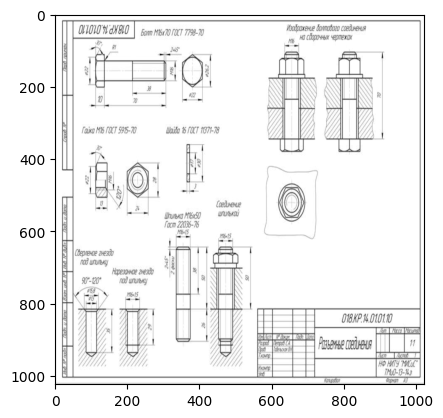

In [8]:
plt.imshow(x_train[0], cmap='gray')

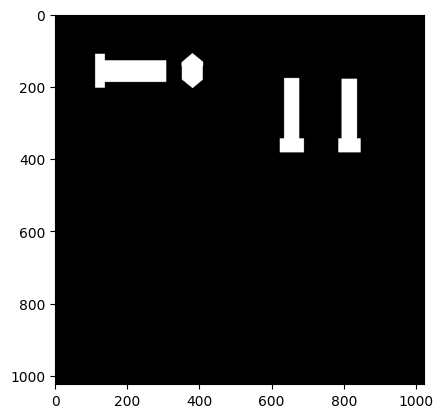

In [9]:
# x,y=next(train_generator)

plt.imshow(y_train[0][:,:,0], cmap='gray')

In [10]:
model.fit(x_train, y_train,steps_per_epoch=train_samples//batch_size,epochs=epochs,batch_size=batch_size)

Epoch 1/20


In [ ]:
model.save('cad_segmentation.h5')

In [ ]:
model = load_model('cad_segmentation.h5')

In [ ]:
img = cv2.imread("1.jpg", cv2.IMREAD_GRAYSCALE)
img=cv2.resize(img, (img_width, img_height)).reshape(1,1024,1024)

pred=model.predict(img)
print(pred.shape)

1/1 [==============================] - 0s 287ms/step
(1, 1024, 1024, 6)


In [ ]:
print(pred[0])

[[[0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  ...
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  ...
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  ...
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]]

 ...

 [[0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  ...
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  ...
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  ...
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1.]]]


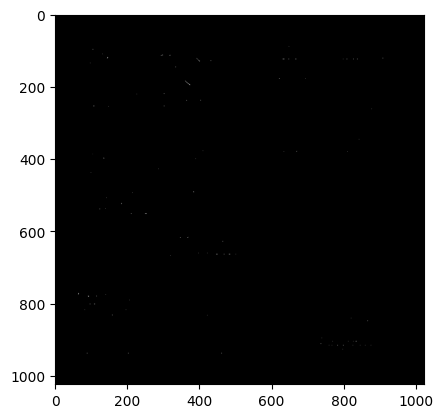

In [ ]:

# plt.imshow(pred.reshape(1024,1024,1))
plt.imshow(pred[0][:,:,0], cmap='gray')

In [ ]:

# Определение классов
class_names = ['bolts','nuts','washers', 'seals', 'bearings']

# Определение порога вероятности для классификации
threshold = 0.5

# Рисование прямоугольников и надписей на изображении
for i in range(len(class_names)):
    # Получение маски для текущего класса
    mask = pred[:, :, i]
    # Поиск контуров на маске
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Рисование прямоугольников и надписей для каждого контура
    for c in contours:
        # Вычисление координат и размеров прямоугольника
        x, y, w, h = cv2.boundingRect(c)
        # Рисование прямоугольника
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        # Надпись с классом и вероятностью
        label = f"{class_names[i]}: {pred[y:y+h, x:x+w, i].max():.2f}"
        cv2.putText(img, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Отображение изображения с прямоугольниками и надписями
cv2.imshow('Predicted Image', img)

error: ignored